In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, silhouette_score, silhouette_samples)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# Get data
df = pd.read_csv("hexapod_data_cleaned.csv")
#

# Parse data
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#

# Fit K-Means and acquire generated labels
scaler_kmeans = StandardScaler()
X_train_scaled = scaler_kmeans.fit_transform(X_train)
X_test_scaled = scaler_kmeans.transform(X_test)

n_clust = y_train.nunique()
kmeans = KMeans(n_clusters=n_clust, random_state=0, n_init="auto")
kmeans.fit(X_train_scaled)
train_cluster_labels = kmeans.labels_
#

# Map generated clusters to labels
cluster_to_label = {}
for c in range(n_clust):
    indices = np.where(train_cluster_labels == c)[0]
    if len(indices) == 0:
        continue
    true_labels_in_cluster = y_train.iloc[indices]
    majority_label = true_labels_in_cluster.value_counts().idxmax()
    cluster_to_label[c] = majority_label
#

# Prints mappings
print("\nCluster -> Label mapping (majority vote):")
for c, lbl in cluster_to_label.items():
    print(f"Cluster {c} -> Label {lbl}")
#

# Creates predictions
y_train_kmeans_pred = np.array([cluster_to_label[c] for c in train_cluster_labels])

# Maps to labels
test_cluster_labels = kmeans.predict(X_test_scaled)
y_test_kmeans_pred = np.array([cluster_to_label.get(c, -999) for c in test_cluster_labels])

# Accuracy with respect to ground truths
kmeans_train_acc = accuracy_score(y_train, y_train_kmeans_pred)
kmeans_test_acc = accuracy_score(y_test, y_test_kmeans_pred)

print(f"\nK-means Train Accuracy (via majority label mapping): {kmeans_train_acc:.4f}")
print(f"K-means Test Accuracy (via majority label mapping):  {kmeans_test_acc:.4f}")

print("\nK-means Classification Report (Test):")
print(classification_report(y_test, y_test_kmeans_pred, zero_division=0.0))
print("\nK-means Confusion Matrix (Test):")
cm = confusion_matrix(y_test, y_test_kmeans_pred)
print(cm)

# Silhoutte Analysis
silhouette_avg = silhouette_score(X_train_scaled, train_cluster_labels)
print(f"\nK-means Average Silhouette Score (Train): {silhouette_avg:.4f}")

print("\nK-means Cluster Centers (in scaled feature space):")
print(kmeans.cluster_centers_)


Cluster -> Label mapping (majority vote):
Cluster 0 -> Label 5
Cluster 1 -> Label 9
Cluster 2 -> Label -1
Cluster 3 -> Label 10
Cluster 4 -> Label 15
Cluster 5 -> Label 13
Cluster 6 -> Label 3
Cluster 7 -> Label 15
Cluster 8 -> Label 6
Cluster 9 -> Label 17
Cluster 10 -> Label 15
Cluster 11 -> Label 6
Cluster 12 -> Label 8
Cluster 13 -> Label 6
Cluster 14 -> Label 15
Cluster 15 -> Label 3
Cluster 16 -> Label 12
Cluster 17 -> Label 12

K-means Train Accuracy (via majority label mapping): 0.3115
K-means Test Accuracy (via majority label mapping):  0.3038

K-means Classification Report (Test):
              precision    recall  f1-score   support

          -1       0.47      0.46      0.47       189
           0       0.00      0.00      0.00       189
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       189
           3       0.34      0.37      0.36       187
           5       0.26      0.53      0.35       176
           6       0.7

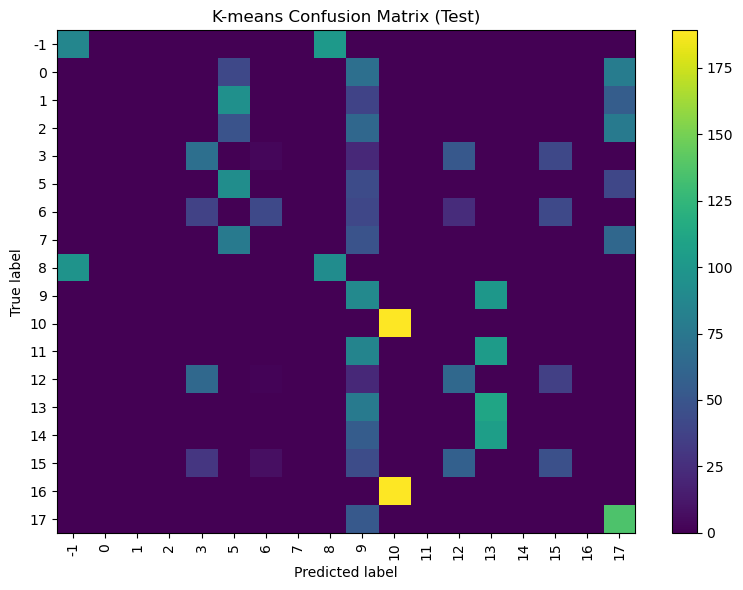

In [2]:
# Confusion matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(cm, aspect='auto')
plt.colorbar(im)
plt.title("K-means Confusion Matrix (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.xticks(ticks=np.arange(len(y_train.unique())), labels=sorted(y_train.unique()), rotation=90)
plt.yticks(ticks=np.arange(len(y_train.unique())), labels=sorted(y_train.unique()))

plt.tight_layout()
plt.show()
#

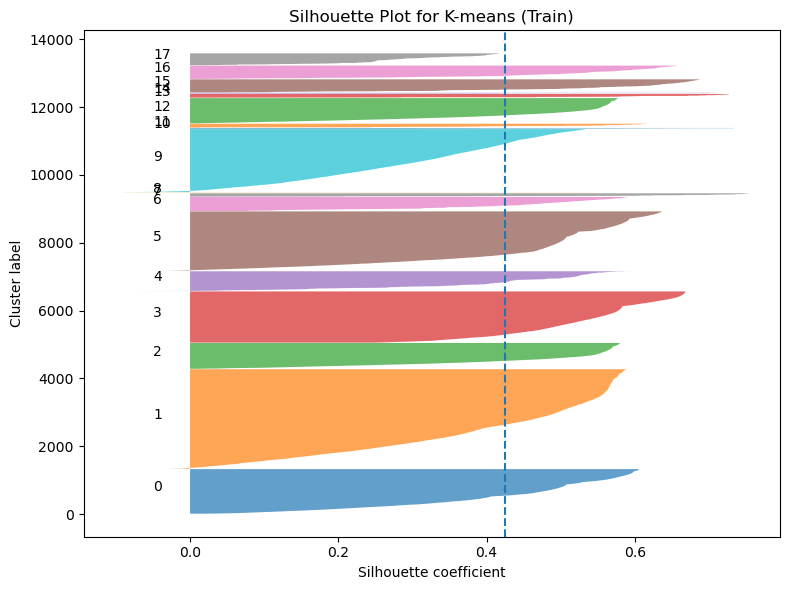

In [3]:
# Silhoutte plot
sil_values = silhouette_samples(X_train_scaled, train_cluster_labels)

plt.figure(figsize=(8, 6))
y_lower = 10
for c in range(n_clust):
    c_sil_values = sil_values[train_cluster_labels == c]
    c_sil_values.sort()

    c_size = c_sil_values.shape[0]
    y_upper = y_lower + c_size

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * c_size, str(c))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, linestyle='--')
plt.title("Silhouette Plot for K-means (Train)")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster label")
plt.tight_layout()
plt.show()
#

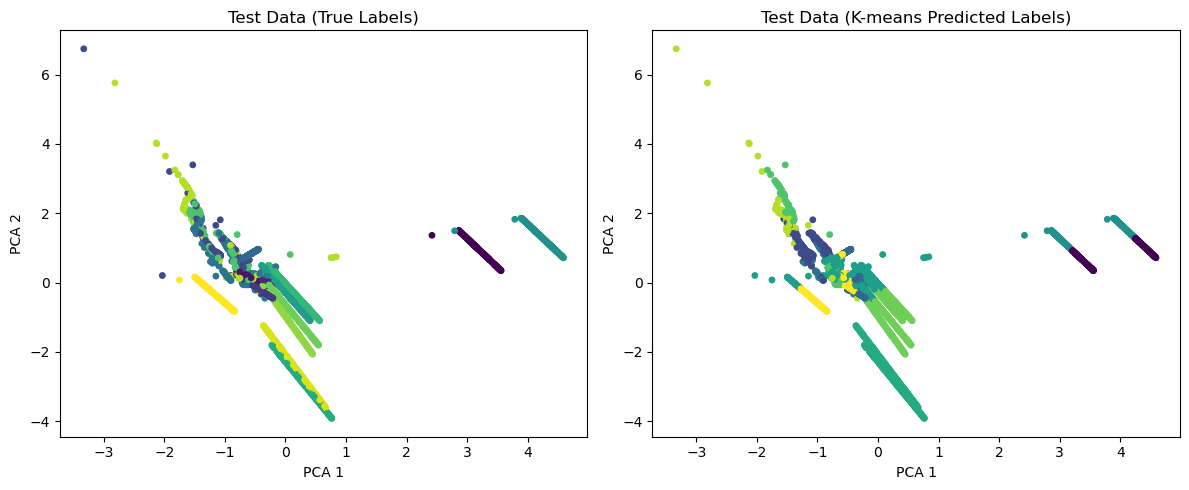

In [4]:
# PCA Projection 
pca = PCA(n_components=2, random_state=0)
X_test_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, s=15)
plt.title("Test Data (True Labels)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_kmeans_pred, s=15)
plt.title("Test Data (K-means Predicted Labels)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()
#